In [ ]:
#!pip install --upgrade numpy pandas tqdm scipy matplotlib statsmodels openpyxl

In [1]:
import os
import numpy as np
import pandas as pd
from numbers import Number
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ks_2samp, wasserstein_distance

def get_stars(p, p001="***", p01="**", p05="*", p10="⁺", p_=""):
    if not isinstance(p, Number):
        return p
    if p < 0.001:
        return p001
    if p < 0.010:
        return p01
    if p < 0.050:
        return p05
    if p < 0.100:
        return p10
    return p_

def deseasonalize_and_detrend(ts):
    result = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')
    return ts - result.trend - result.seasonal

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = '../'
data_dir = os.path.join(base_dir, "data")
misc_dir = os.path.join(base_dir, "misc")

In [3]:
bv = pd.read_csv(os.path.join(data_dir, 'bvisuals.csv'), 
                        parse_dates=True, index_col=0, sep=';')
mt = pd.read_csv(os.path.join(data_dir, 'mempool.csv'), 
                        parse_dates=True, index_col=0, sep=';')
dd = pd.read_csv(os.path.join(data_dir, 'diameter.csv'), 
                        parse_dates=True, index_col=0, sep=';')
mt.drop('capacity', axis=1, inplace=True)
fs = pd.read_csv(os.path.join(data_dir, 'shapes.geo.csv'), parse_dates=True, index_col=1)\
        .rename(columns={'edges': 'channels'}).fillna(0)
fs.drop(['file_name', 'timestamp'], axis=1, inplace=True)

fs = fs.asfreq('D').interpolate().resample('1M').mean() #method='pchip'
mt = mt.asfreq('D').interpolate().resample('1M').mean()
bv = bv.asfreq('D').interpolate().resample('1M').mean()
dd = dd.asfreq('D').interpolate().resample('1M').mean()
df = pd.merge(fs.reset_index(), mt.reset_index(), 
              how='left', on='datetime',
              suffixes=('_fs', '_mt'))
df = pd.merge(df, bv.reset_index()\
              .rename(columns={'nodes' : 'nodes_bv',
                               'channels' : 'channels_bv'}), 
              how='left', on='datetime')
df = pd.merge(df, dd.reset_index(), 
              how='left', on='datetime',
              suffixes=('_fs', '_bv'))
df = df.set_index('datetime').asfreq('1M').dropna()
for c in df.columns:
    df[f"{c}_"] = deseasonalize_and_detrend(df[c])


In [4]:
geocoded = df.geocoded_nodes / df.nodes_fs
print(f"geocoded share: {geocoded.mean():.2f}±{geocoded.std():.2f}")

geocoded share: 0.39±0.15


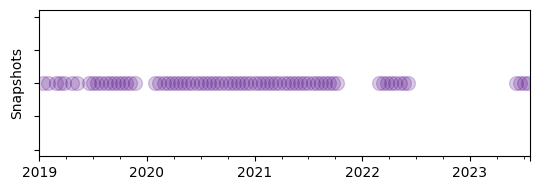

In [87]:
fs = pd.read_csv(os.path.join(data_dir, 'shapes.csv'), parse_dates=True, index_col=1)\
        .rename(columns={'edges': 'channels'}).fillna(0)
fs.drop(['file_name', 'timestamp'], axis=1, inplace=True)
fs = fs.asfreq('D').resample('2W').max()#.astype(int)
fs['idx'] = fs['nodes'].apply(lambda x: 1 if pd.notna(x) else x)
fig = plt.figure(figsize=(5.5, 2))    
ax = fig.add_subplot()
fs['idx'].plot(ax=ax, color='indigo', alpha=0.2, style='o', label='', markersize=10)
ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))

ax.set_ylabel('Snapshots')
ax.set_xlabel(None)
ax.set_yticklabels([''])

fig.tight_layout()
fig.savefig(os.path.join(misc_dir, 'fig2.png'), dpi=1200, bbox_inches='tight', format='png')

In [5]:
def metrics(a, b):
    ks_stat, ks_p = ks_2samp(a, b)
    wd = wasserstein_distance(a, b) / np.max(pd.concat([a, b]))
    return ks_stat, ks_p, wd

pairs = {(i, 'MP') : (df[i+'_fs'], df[i+'_mt'])
         for i in ['nodes', 'channels', 'diameter']
         if i+'_mt' in df}
pairs.update({(i, 'BV') : (df[i+'_fs'], df[i+'_bv'])
         for i in ['nodes', 'channels', 'diameter']
         if i+'_bv' in df})
pairs.update({(i, 'MP_') : (df[i+'_fs_'], df[i+'_mt_'])
         for i in ['nodes', 'channels', 'diameter']
         if i+'_mt_' in df})
pairs.update({(i, 'BV_') : (df[i+'_fs_'], df[i+'_bv_'])
         for i in ['nodes', 'channels', 'diameter']
         if i+'_bv_' in df})
res = {k : metrics(v[0], v[1]) for k, v in pairs.items()}
res = pd.DataFrame(res)
res = pd.DataFrame((
    [f"{res[c].iloc[0]:.3f}{get_stars(res[c].iloc[1])}" for c in res.columns],
    [f"{res[c].iloc[2]:.3f}" for c in res.columns]), 
    columns=res.columns, index=['KS', 'WD'])
res.to_excel(os.path.join(misc_dir, 'tab1.xlsx'))
res


,nodes,channels,nodes,channels,diameter,nodes,channels,nodes,channels,diameter
,MP,MP,BV,BV,BV,MP_,MP_,BV_,BV_,BV_
KS,0.091,0.091,0.327**,0.418***,0.364**,0.091,0.091,0.145,0.091,0.182
WD,0.005,0.016,0.067,0.098,0.091,0.025,0.053,0.073,0.104,0.082


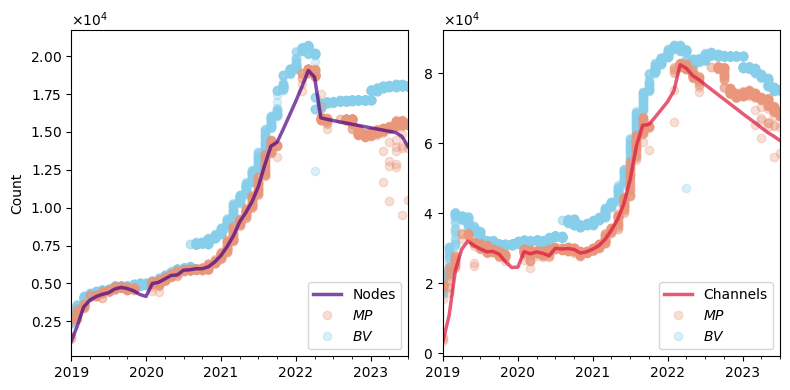

In [88]:
bv = pd.read_csv(os.path.join(data_dir, 'bvisuals.csv'), 
                        parse_dates=True, index_col=0, sep=';')
mt = pd.read_csv(os.path.join(data_dir, 'mempool.csv'), 
                        parse_dates=True, index_col=0, sep=';')
mt.drop('capacity', axis=1, inplace=True)
mt = mt[(mt['nodes'] > 1300)]
fs = pd.read_csv(os.path.join(data_dir, 'shapes.csv'), parse_dates=True, index_col=1)\
        .rename(columns={'edges': 'channels'}).fillna(0)
fs.drop(['file_name', 'timestamp'], axis=1, inplace=True)
fs = fs.asfreq('D').interpolate().resample('1M').mean()#.astype(int)

fig = plt.figure(figsize=(8, 4))    
ax = fig.add_subplot(1, 2, 1)
fs[['nodes']].rename(columns={'nodes': '_A'})\
                        .plot(ax=ax, linewidth=0.001)
bv[['nodes']].rename(columns={'nodes': '$BV$'})\
        .plot(ax=ax, style='o', lw=0.3, color='skyblue', alpha=0.3)
mt[['nodes']].rename(columns={'nodes': '$MP$'})\
        .plot(ax=ax, style='o', lw=0.3, color='darksalmon', alpha=0.3)
fs[['nodes']].rename(columns={'nodes': 'Nodes'})\
        .plot(ax=ax, linewidth=2.5, color='indigo', 
            alpha=0.7)
    
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(xfmt)
ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))
ax.set_ylabel('Count')
ax.set_xlabel(None)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), 
                                reverse=True,
                                key=lambda t: t[0]))
ax.legend(handles[:4], labels[:4], loc='lower right')

ax = fig.add_subplot(1, 2, 2)
fs[['channels']].rename(columns={'channels': '_A'})\
                        .plot(ax=ax, linewidth=0.001)
bv[['channels']].rename(columns={'channels': '$BV$'})\
        .plot(ax=ax, style='o', lw=0.3, color='skyblue', alpha=0.3)
mt[['channels']].rename(columns={'channels': '$MP$'})\
        .plot(ax=ax, style='o', lw=0.3, color='darksalmon', alpha=0.3)
fs[['channels']].rename(columns={'channels': 'Channels'})\
        .plot(ax=ax, linewidth=2.5, color='crimson', 
            alpha=0.7)

xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(xfmt)
ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))
#ax.set_ylabel('number')
ax.set_xlabel(None)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), 
                                reverse=True,
                                key=lambda t: t[0]))
ax.legend(handles[:4], labels[:4], loc='lower right')

fig.tight_layout()
fig.savefig(os.path.join(misc_dir, 'fig3.png'), dpi=1200, bbox_inches='tight', format='png')